In [1]:
import random
import numpy as np

random.seed(2)
np.random.seed(2)

In [2]:
!pip install spacy
!pip install rank-bm25
!pip install nmslib
!pip install python-terrier


import os
import pandas as pd
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import time
import nmslib
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 24.3 MB/s eta 0:00:0

<ipython-input-2-b04f679a080b>:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
df = pd.read_csv('run_resultslong.csv')
df['text'] = df['Tender_name'] + ' ' + df['Tender_Desc']+ ' ' + df['Tender_Publication_date']+ ' ' + df['Tender_Closing_date']+ ' ' + df['Tender_Contract_value']+ ' ' + df['Tender_Tender_by']
df.dtypes


Tender_name                object
Tender_Desc                object
Tender_Publication_date    object
Tender_Closing_date        object
Tender_Contract_value      object
Tender_Tender_by           object
text                       object
dtype: object

In [4]:
df.head(5)

,Tender_name,Tender_Desc,Tender_Publication_date,Tender_Closing_date,Tender_Contract_value,Tender_Tender_by,text
0,Local Community Training To Support Patients and Carers in the Black Community,You are invited to submit a tender for the Authority's requirement for Local Community Training to Support Patients and Carers in the Black Community (PCREF). The South London and Maudsley Trust has a requirement to deliver local community training to support patients and carers in the black community in the following boroughs: • Lambeth ...,Publication date 3 March 2023,"Closing 12 April 2023, 12pm",Contract value £0,South London and Maudsley NHS Foundation Trust,"Local Community Training To Support Patients and Carers in the Black Community You are invited to submit a tender for the Authority's requirement for Local Community Training to Support Patients and Carers in the Black Community (PCREF). The South London and Maudsley Trust has a requirement to deliver local community training to support patients and carers in the black community in the following boroughs: • Lambeth ... Publication date 3 March 2023 Closing 12 April 2023, 12pm Contract value £0 South London and Maudsley NHS Foundation Trust"
1,The Internal refurbishment to ground floor of Library Polhill Campus,"Internal refurbishment to ground floor of library - University of Bedfrdshire, Polhill Campus",Publication date 3 March 2023,"Closing 31 March 2023, 12pm","Contract value £120,000",University Of Bedfordshire,"The Internal refurbishment to ground floor of Library Polhill Campus Internal refurbishment to ground floor of library - University of Bedfrdshire, Polhill Campus Publication date 3 March 2023 Closing 31 March 2023, 12pm Contract value £120,000 University Of Bedfordshire"
2,PS23044 - A synthesis of trends for the future of our towns and cities,The final date and time for the submission of bids is day 31st March 2023 at 11:00. DO NOT apply directly to the buyer. All tender information MUST be submitted through the Jaggaer eSourcing Portal. Brief Description of Requirement: Much research has been carried out into what the future of towns and cities may be and what they may look like. ...,Publication date 3 March 2023,"Closing 31 March 2023, 11am","Contract value £0 to £60,000","Department for Business, Energy & Industrial Strategy","PS23044 - A synthesis of trends for the future of our towns and cities The final date and time for the submission of bids is day 31st March 2023 at 11:00. DO NOT apply directly to the buyer. All tender information MUST be submitted through the Jaggaer eSourcing Portal. Brief Description of Requirement: Much research has been carried out into what the future of towns and cities may be and what they may look like. ... Publication date 3 March 2023 Closing 31 March 2023, 11am Contract value £0 to £60,000 Department for Business, Energy & Industrial Strategy"
3,Grounds Maintenance Services,"The provision of Grounds Maintenance works on a planned maintenance and minor project works basis throughout the Force estate. The works included in this contract are those necessary to maintain the external areas at specified sites to an acceptable standard, all in accordance with the specification and in conjunction with a proactive approach to ...",Publication date 3 March 2023,"Closing 31 March 2023, 12pm","Contract value £700,000 to £800,000",Greater Manchester Combined Authority - Greater Manchester Police,"Grounds Maintenance Services The provision of Grounds Maintenance works on a planned maintenance and minor project works basis throughout the Force estate. The works included in this contract are those necessary to maintain the external areas at specified sites to an acceptable standard, all in accordance with the specification and in conjunction with a proactive approach to ... Publication date 3 March 2023 Closing 31 March 2023, 12pm Contract value £700,000 to £800,000 Greater Manchester Combined Authority - Greater Manchester Police"
4,Ice Cre

In [5]:
def fix_text(x):
  """This function does nothing but leaving
  here as a placeholder for basic text cleaning"""
  return x

nlp = spacy.load("en_core_web_sm")
tok_text=[] 
text = df.text.str.lower().values
text = [fix_text(str(i)) for i in text]

#Tokenising using SpaCy:

for doc in tqdm(nlp.pipe(text, disable=["tagger", "parser","ner"]), total=len(text), desc="Tokenizing text"):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)

Tokenizing text:   0%|          | 0/2529 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Tokenizing text: 100%|██████████| 2529/2529 [00:20<00:00, 122.79it/s]


In [6]:
from gensim.models import FastText

ft_model = FastText(
    sg=1, 
    vector_size=100, 
    window=10, 
    min_count=5, 
    negative=15, 
    min_n=2, 
    max_n=5 
)
ft_model.build_vocab(tok_text) 

ft_model.train(
    tok_text,
    epochs=10,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model') 
ft_model = FastText.load('_fasttext.model') 


In [7]:
ft_model = FastText.load('_fasttext.model')

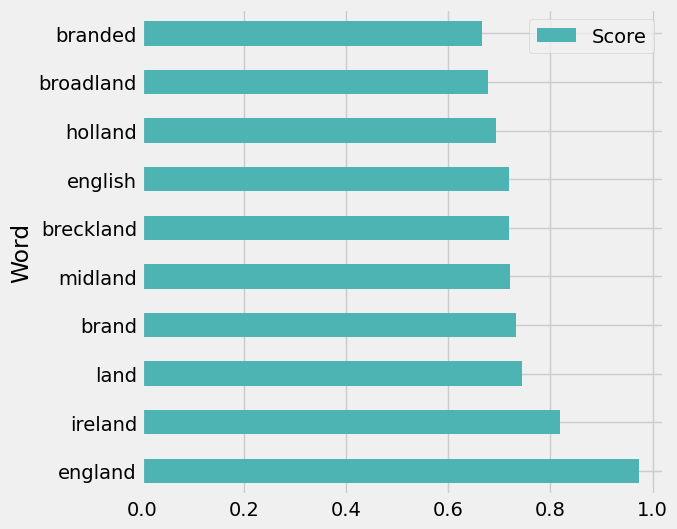

In [8]:
similar_words = pd.DataFrame(ft_model.wv.most_similar("England", topn=10, restrict_vocab=5000), columns=['Word','Score'])
similar_words.plot.barh(x='Word', figsize=(6,6), color=(0.3,0.7,0.7));

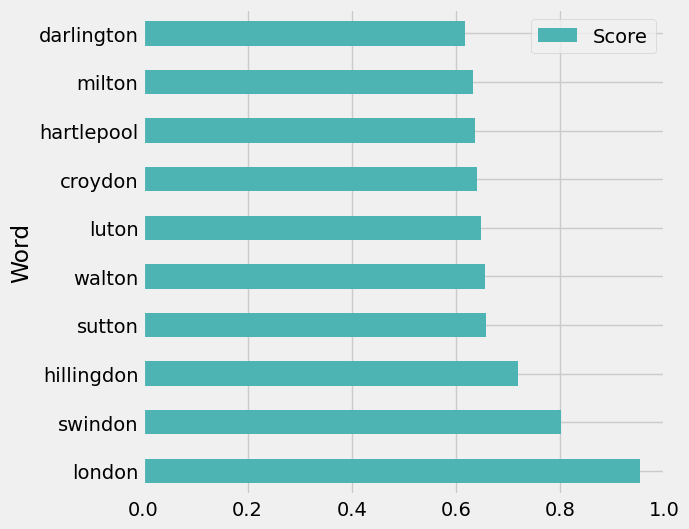

In [9]:
similar_words = pd.DataFrame(ft_model.wv.most_similar("London", topn=10, restrict_vocab=5000), columns=['Word','Score'])
similar_words.plot.barh(x='Word', figsize=(6,6), color=(0.3,0.7,0.7));

In [10]:
from rank_bm25 import BM25Okapi
import numpy as np
from tqdm import tqdm

bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i, doc in tqdm(enumerate(tok_text)):
    doc_vector = []
    for word in doc:
        try:
            vector = ft_model.wv[word]
            weight = (bm25.idf[word] * ((bm25.k1 + 1.0) * bm25.doc_freqs[i][word])) / (bm25.k1 * (1.0 - bm25.b + bm25.b * (bm25.doc_len[i] / bm25.avgdl)) + bm25.doc_freqs[i][word])
            weighted_vector = vector * weight
            doc_vector.append(weighted_vector)
        except KeyError:
            continue
    doc_vector_mean = np.mean(doc_vector, axis=0)
    weighted_doc_vects.append(doc_vector_mean)


2529it [00:01, 1304.03it/s]


In [11]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

In [12]:
with open( "weighted_doc_vects.p", "rb" ) as f:
  weighted_doc_vects = pickle.load(f)

data = np.vstack(weighted_doc_vects)

# initializing  a new index using a HNSW index on cosine similarity 

index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [13]:
import time

input = 'services'.lower().split()

query = [ft_model.wv[vec] for vec in input]
query = np.mean(query, axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
print('Top 10 documents with highest similarity scores for BM25 model \n')  

for i, j in zip(ids, distances):
    print(round(j,2))
    print(df.Tender_Tender_by.values[i])


results = []

for i, j in zip(ids, distances):
    results.append({
        'Similarity Score (BM25)': round(j, 2),
        'Relevant Documents (Tender_by)': df.Tender_Tender_by.values[i]
    })

results_df = pd.DataFrame(results)

# Display the results_df DataFrame
display(results_df)


Searched 2529 records in 0.0003 seconds 

Top 10 documents with highest similarity scores for BM25 model 

0.31
Kent County Council (t/a Procurement Services)
0.31
London Universities Purchasing Consortium
0.31
PROSPER
0.31
Homes England (the name adopted by the Homes and Communities Agency)
0.32
Livv Housing Group
0.32
Staffordshire County Council
0.32
Leicestershire County Council
0.32
Herefordshire Council
0.32
Arts Council England
0.32
Leicestershire Police


,Similarity Score (BM25),Relevant Documents (Tender_by)
0,0.31,Kent County Council (t/a Procurement Services)
1,0.31,London Universities Purchasing Consortium
2,0.31,PROSPER
3,0.31,Homes England (the name adopted by the Homes and Communities Agency)
4,0.32,Livv Housing Group
5,0.32,Staffordshire County Council
6,0.32,Leicestershire County Council
7,0.32,Herefordshire Council
8,0.32,Arts Council England
9,0.32,Leicestershire Police


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
df = df.dropna()

In [15]:
# define a function to evaluate the BM25 search engine

def evaluate_search_engine(query, relevant_docs, top_k=5):
    
    query = query.lower().split()
    
    # get the top k most similar documents to the query

    query_vec = [ft_model.wv[vec] for vec in query]
    query_vec = np.mean(query_vec, axis=0)
    ids, distances = index.knnQuery(query_vec, k=top_k)
    
    # retrieve the text of the top k most similar documents

    retrieved_docs = df.loc[ids, 'Tender_Tender_by'].values
    
    # calculate the precision, recall, and F1-score of the BM25 search engine

    relevant_docs = set(relevant_docs)
    retrieved_docs = set(retrieved_docs)
    true_positives = len(relevant_docs & retrieved_docs)
    precision = true_positives / top_k
    recall = true_positives / len(relevant_docs)
    
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    

    return precision, recall, f1_score


In [16]:
# BM25 Evaluation

query = "services"

relevant_docs = ['Cornwall College e-Tendering','FCO Services','PROSPER']

print("\nTop 10 Documents with Similarity Scores:")
display(results_df)

precision, recall, f1_score = evaluate_search_engine(query, relevant_docs)
print(f"\nEvaluation Metrics for BM25 based on the query 'services':")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")


Top 10 Documents with Similarity Scores:


,Similarity Score (BM25),Relevant Documents (Tender_by)
0,0.31,Kent County Council (t/a Procurement Services)
1,0.31,London Universities Purchasing Consortium
2,0.31,PROSPER
3,0.31,Homes England (the name adopted by the Homes and Communities Agency)
4,0.32,Livv Housing Group
5,0.32,Staffordshire County Council
6,0.32,Leicestershire County Council
7,0.32,Herefordshire Council
8,0.32,Arts Council England
9,0.32,Leicestershire Police



Evaluation Metrics for BM25 based on the query 'services':
Precision: 0.2
Recall: 0.3333333333333333
F1-score: 0.25


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

query = "services"

# Create a TfidfVectorizer, fitting it to the docs, transforming thr query into a TF-IDF vector

vectorizer = TfidfVectorizer()
vectorizer.fit(df['Tender_Tender_by'])
query_vector = vectorizer.transform([query])
document_matrix = vectorizer.transform(df['Tender_Tender_by'])

# Calculating the cosine similarity between the query vector and doc matrix

similarity_scores = cosine_similarity(query_vector, document_matrix)

# Get the top 10 indices with the highest similarity scores

top_10_indices = similarity_scores[0].argsort()[-10:][::-1]

# Get the top 10 similarity scores

top_10_distances = similarity_scores[0][top_10_indices]

def calculate_metrics(predicted_docs, relevant_docs):
    true_positives = len(set(predicted_docs) & set(relevant_docs))
    false_positives = len(set(predicted_docs) - set(relevant_docs))
    false_negatives = len(set(relevant_docs) - set(predicted_docs))

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score



In [18]:
import pandas as pd

t0 = time.time()

print(f'Searched {df.shape[0]} records in {round(time.time() - t0, 4)} seconds \n')
print('Top 10 documents with highest similarity scores for TF-IDF model \n')  

for i, j in zip(top_10_indices, top_10_distances):
    print(round(j, 2))
    print(df.Tender_Tender_by.values[i])

query = "services"
relevant_docs = ['Cornwall College e-Tendering', 'FCO Services', 'PROSPER']

# Store the top 10 documents and their similarity scores in a list
top_10_results = []

for i, j in zip(top_10_indices, top_10_distances):
    doc_name = df.Tender_Tender_by.values[i]
    top_10_results.append({
        'Document Name': doc_name,
        'Similarity Score (TF-IDF)': round(j, 2)
    })

# Create a DataFrame with the top 10 documents and their similarity scores
top_10_docs_df = pd.DataFrame(top_10_results)

# Display the DataFrame
print("\nTop 10 Documents with Similarity Scores for TF-IDF model:")
display(top_10_docs_df)

# Calculate the evaluation metrics
precision, recall, f1_score = calculate_metrics(top_10_docs_df['Document Name'].values, relevant_docs)
print(f"\nEvaluation Metrics for TF-IDF based on the query 'services':")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


Searched 2342 records in 0.0004 seconds 

Top 10 documents with highest similarity scores for TF-IDF model 

0.71
Commercial Services
0.55
FCO Services
0.55
FCO Services
0.53
FCDO Services
0.5
Kent County Council (t/a Procurement Services)
0.5
Kent County Council (t/a Procurement Services)
0.5
Kent County Council (T/A Procurement Services)
0.49
7 Force Commercial Services
0.49
7 Force Commercial Services
0.49
7 Force Commercial Services

Top 10 Documents with Similarity Scores for TF-IDF model:


,Document Name,Similarity Score (TF-IDF)
0,Commercial Services,0.71
1,FCO Services,0.55
2,FCO Services,0.55
3,FCDO Services,0.53
4,Kent County Council (t/a Procurement Services),0.50
5,Kent County Council (t/a Procurement Services),0.50
6,Kent County Council (T/A Procurement Services),0.50
7,7 Force Commercial Services,0.49
8,7 Force Commercial Services,0.49
9,7 Force Commercial Services,0.49



Evaluation Metrics for TF-IDF based on the query 'services':
Precision: 0.1667
Recall: 0.3333
F1-score: 0.2222


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the IDF model using TfidfVectorizer
vectorizer_idf = TfidfVectorizer(use_idf=True)
vectorizer_idf.fit(df['Tender_Desc'])

# Calculate the term-document matrix for the IDF model
term_document_matrix_idf = vectorizer_idf.transform(df['Tender_Desc'])

# Transform the query using the same vectorizer
query = "services"
query_vector_idf = vectorizer_idf.transform([query])


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_metrics(predicted_docs, relevant_docs):
    true_positives = len(set(predicted_docs) & set(relevant_docs))
    false_positives = len(set(predicted_docs) - set(relevant_docs))
    false_negatives = len(set(relevant_docs) - set(predicted_docs))

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

df['Tender_Desc'].fillna('', inplace=True)


vectorizer = TfidfVectorizer()
vectorizer.fit(df['Tender_Desc'])

term_document_matrix = vectorizer.transform(df['Tender_Desc'])

query_vector = vectorizer.transform([query])
similarity_scores = cosine_similarity(query_vector, term_document_matrix)

top_10_indices_idf = similarity_scores[0].argsort()[-10:][::-1]
top_10_titles_idf = [df['Tender_Tender_by'].iloc[i] for i in top_10_indices_idf]

# Define the relevant document titles

relevant_docs = ['Cornwall College e-Tendering','FCO Services','PROSPER']


# Evaluate the metrics using document titles
predicted_docs_idf_titles = set(top_10_titles_idf)
relevant_docs = set(relevant_docs)
precision, recall, f1_score = evaluate_metrics(predicted_docs_idf_titles, relevant_docs)

from sklearn.metrics.pairwise import cosine_similarity


cosine_similarities_idf = cosine_similarity(query_vector_idf, term_document_matrix_idf)

# Calculate top 10 indices and scores for IDF model
top_10_indices_idf = cosine_similarities_idf[0].argsort()[-10:][::-1]
top_10_idf_scores = cosine_similarities_idf[0][top_10_indices_idf]

# Create the top_10_idf_docs_df DataFrame using top_10_indices_idf and top_10_idf_scores
top_10_document_names_idf = [df['Tender_Tender_by'].values[i] for i in top_10_indices_idf]
top_10_idf_docs_df = pd.DataFrame(list(zip(top_10_document_names_idf, top_10_idf_scores)), columns=['Document Name', 'Similarity Score (IDF)'])

print("Top 10 Documents with Similarity Scores (IDF):")
display(top_10_idf_docs_df)

print(f"\nEvaluation Metrics for IDF based on the query 'services':")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Top 10 Documents with Similarity Scores (IDF):


,Document Name,Similarity Score (IDF)
0,Crown Commercial Service,0.482043
1,Arts Council England,0.366272
2,Cornwall College e-Tendering,0.310728
3,Lancashire County Council,0.294140
4,North Yorkshire County Council,0.287186
5,BRITISH COUNCIL(THE),0.283567
6,Salix Homes Limited,0.264830
7,Anchor Hanover,0.251543
8,United Lincolnshire NHS Trust,0.244868
9,London Borough of Redbridge,0.234208



Evaluation Metrics for IDF based on the query 'services':
Precision: 0.1
Recall: 0.3333333333333333
F1 Score: 0.15384615384615383


In [21]:
t0 = time.time()

print(f'Searched {df.shape[0]} records in {round(time.time() - t0, 4)} seconds \n')
print('Top 10 documents with highest similarity scores for IDF model \n')  

for i, j in zip(top_10_indices_idf, top_10_idf_scores):
    print(round(j, 2))
    print(df.Tender_Tender_by.values[i])

Searched 2342 records in 0.0001 seconds 

Top 10 documents with highest similarity scores for IDF model 

0.48
Crown Commercial Service
0.37
Arts Council England
0.31
Cornwall College e-Tendering
0.29
Lancashire County Council
0.29
North Yorkshire County Council
0.28
BRITISH COUNCIL(THE)
0.26
Salix Homes Limited
0.25
Anchor Hanover
0.24
United Lincolnshire NHS Trust
0.23
London Borough of Redbridge


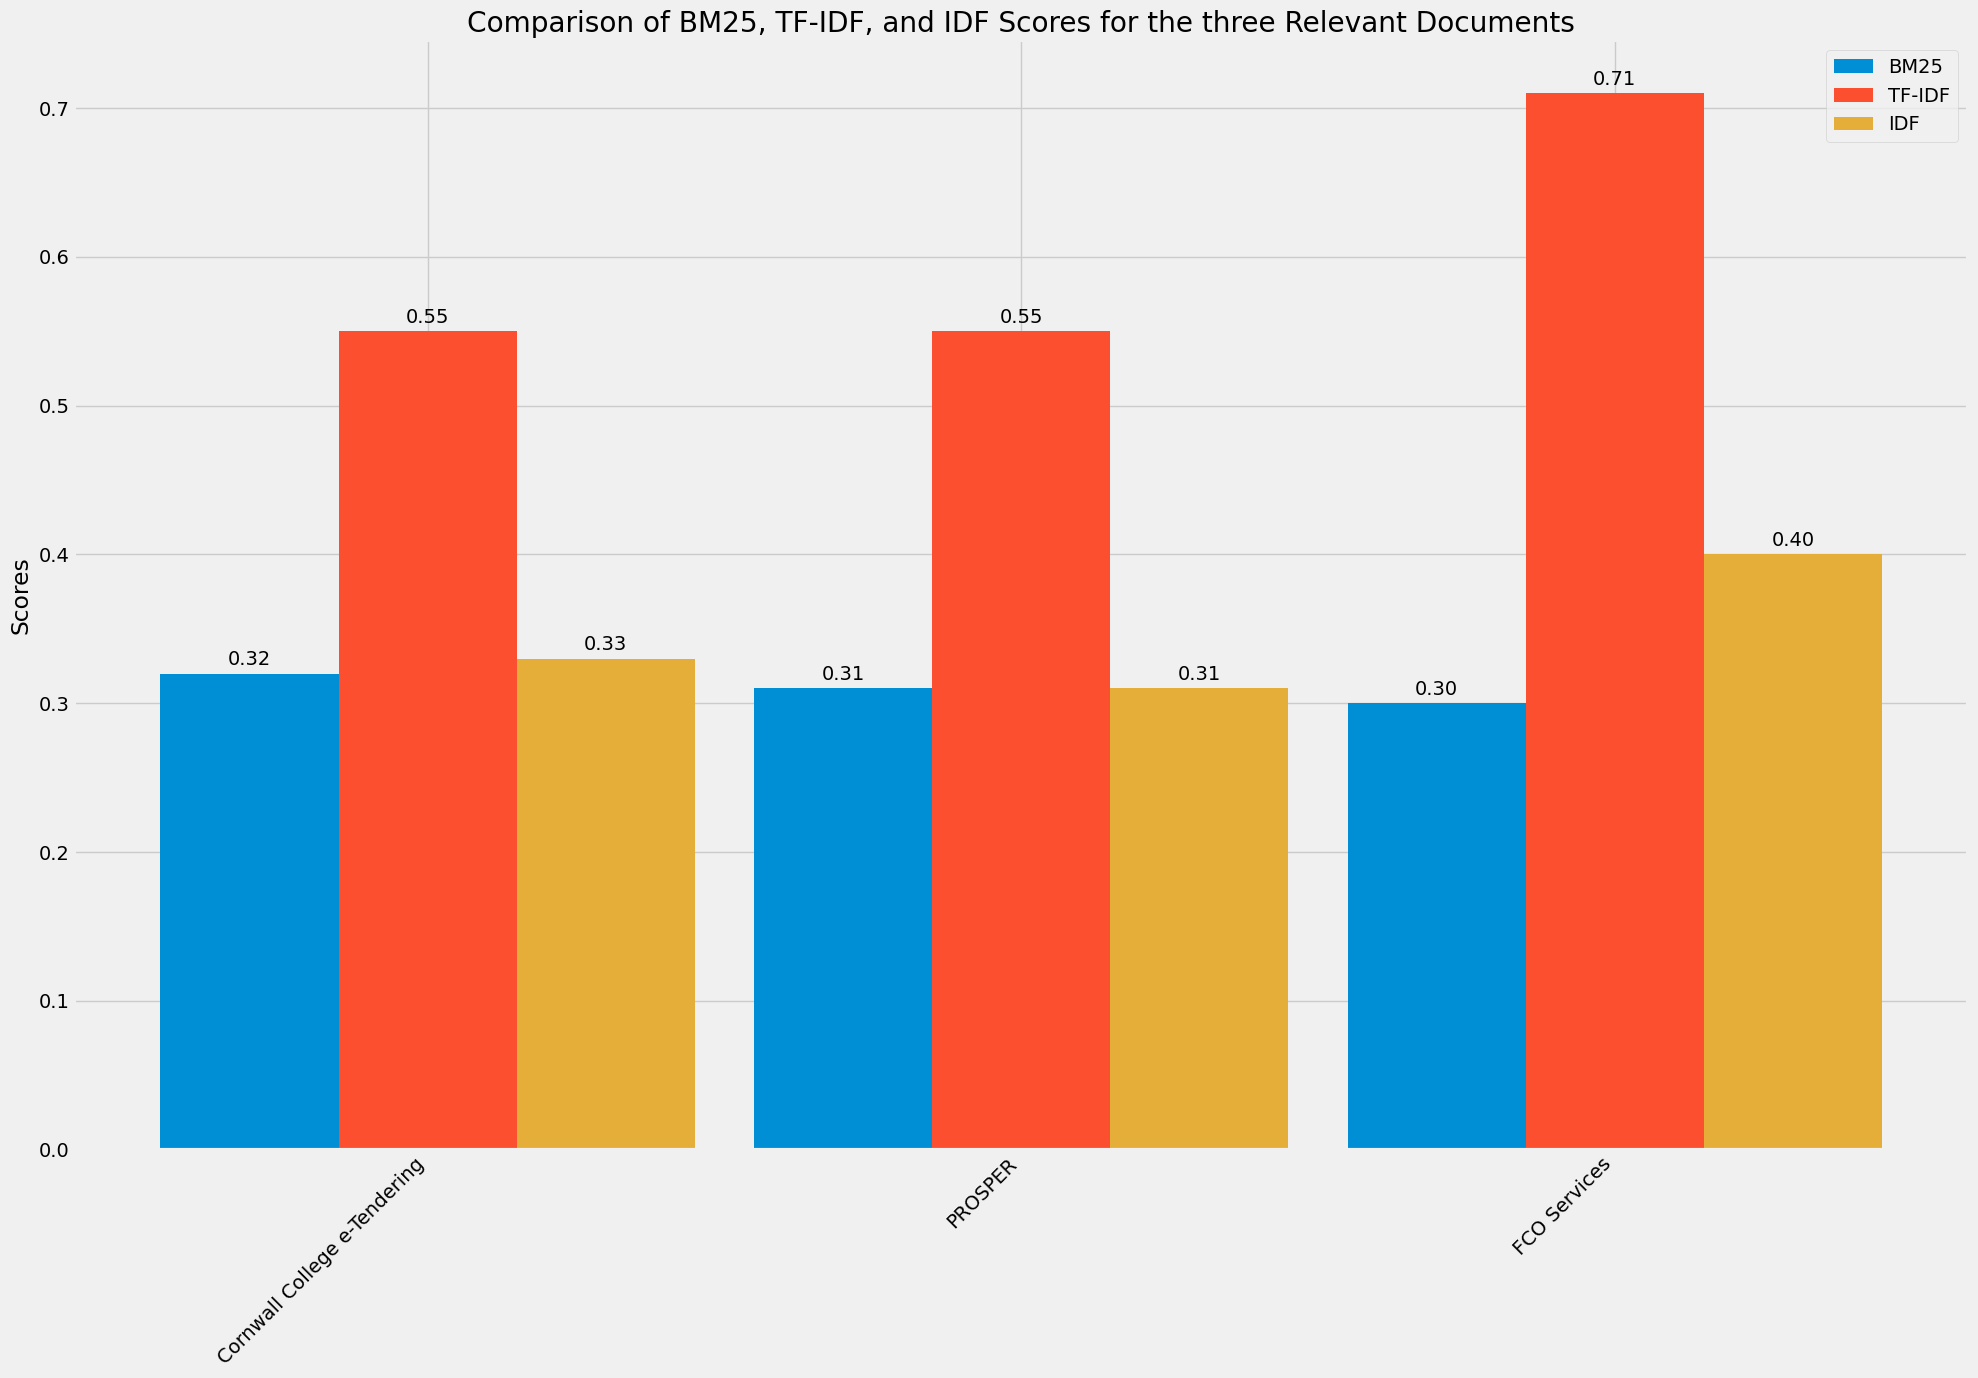

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the similarity scores for the relevant documents
bm25_scores = [0.32, 0.31, 0.30] 
tfidf_scores = [0.55, 0.55, 0.71]  
idf_scores = [0.33, 0.31, 0.40]  

# Create a combined DataFrame
relevant_docs = ['Cornwall College e-Tendering', 'PROSPER', 'FCO Services']
document_names = relevant_docs

combined_df = pd.DataFrame(list(zip(document_names, bm25_scores, tfidf_scores, idf_scores)), 
                           columns=['Relevant Documents', 'BM25', 'TF-IDF', 'IDF'])

# Sort the combined DataFrame by BM25 scores
combined_df.sort_values('BM25', ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# Update the values after sorting
bm25_scores = combined_df['BM25'].values
tfidf_scores = combined_df['TF-IDF'].values
idf_scores = combined_df['IDF'].values
document_names = combined_df['Relevant Documents'].values

ind = np.arange(len(bm25_scores))
width = 0.3

fig, ax = plt.subplots(figsize=(20, 14))
rects1 = ax.bar(ind - width, bm25_scores, width, label='BM25')
rects2 = ax.bar(ind, tfidf_scores, width, label='TF-IDF')
rects3 = ax.bar(ind + width, idf_scores, width, label='IDF')

ax.set_ylabel('Scores')
ax.set_title('Comparison of BM25, TF-IDF, and IDF Scores for the three Relevant Documents')
ax.set_xticks(ind)
ax.set_xticklabels(document_names, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


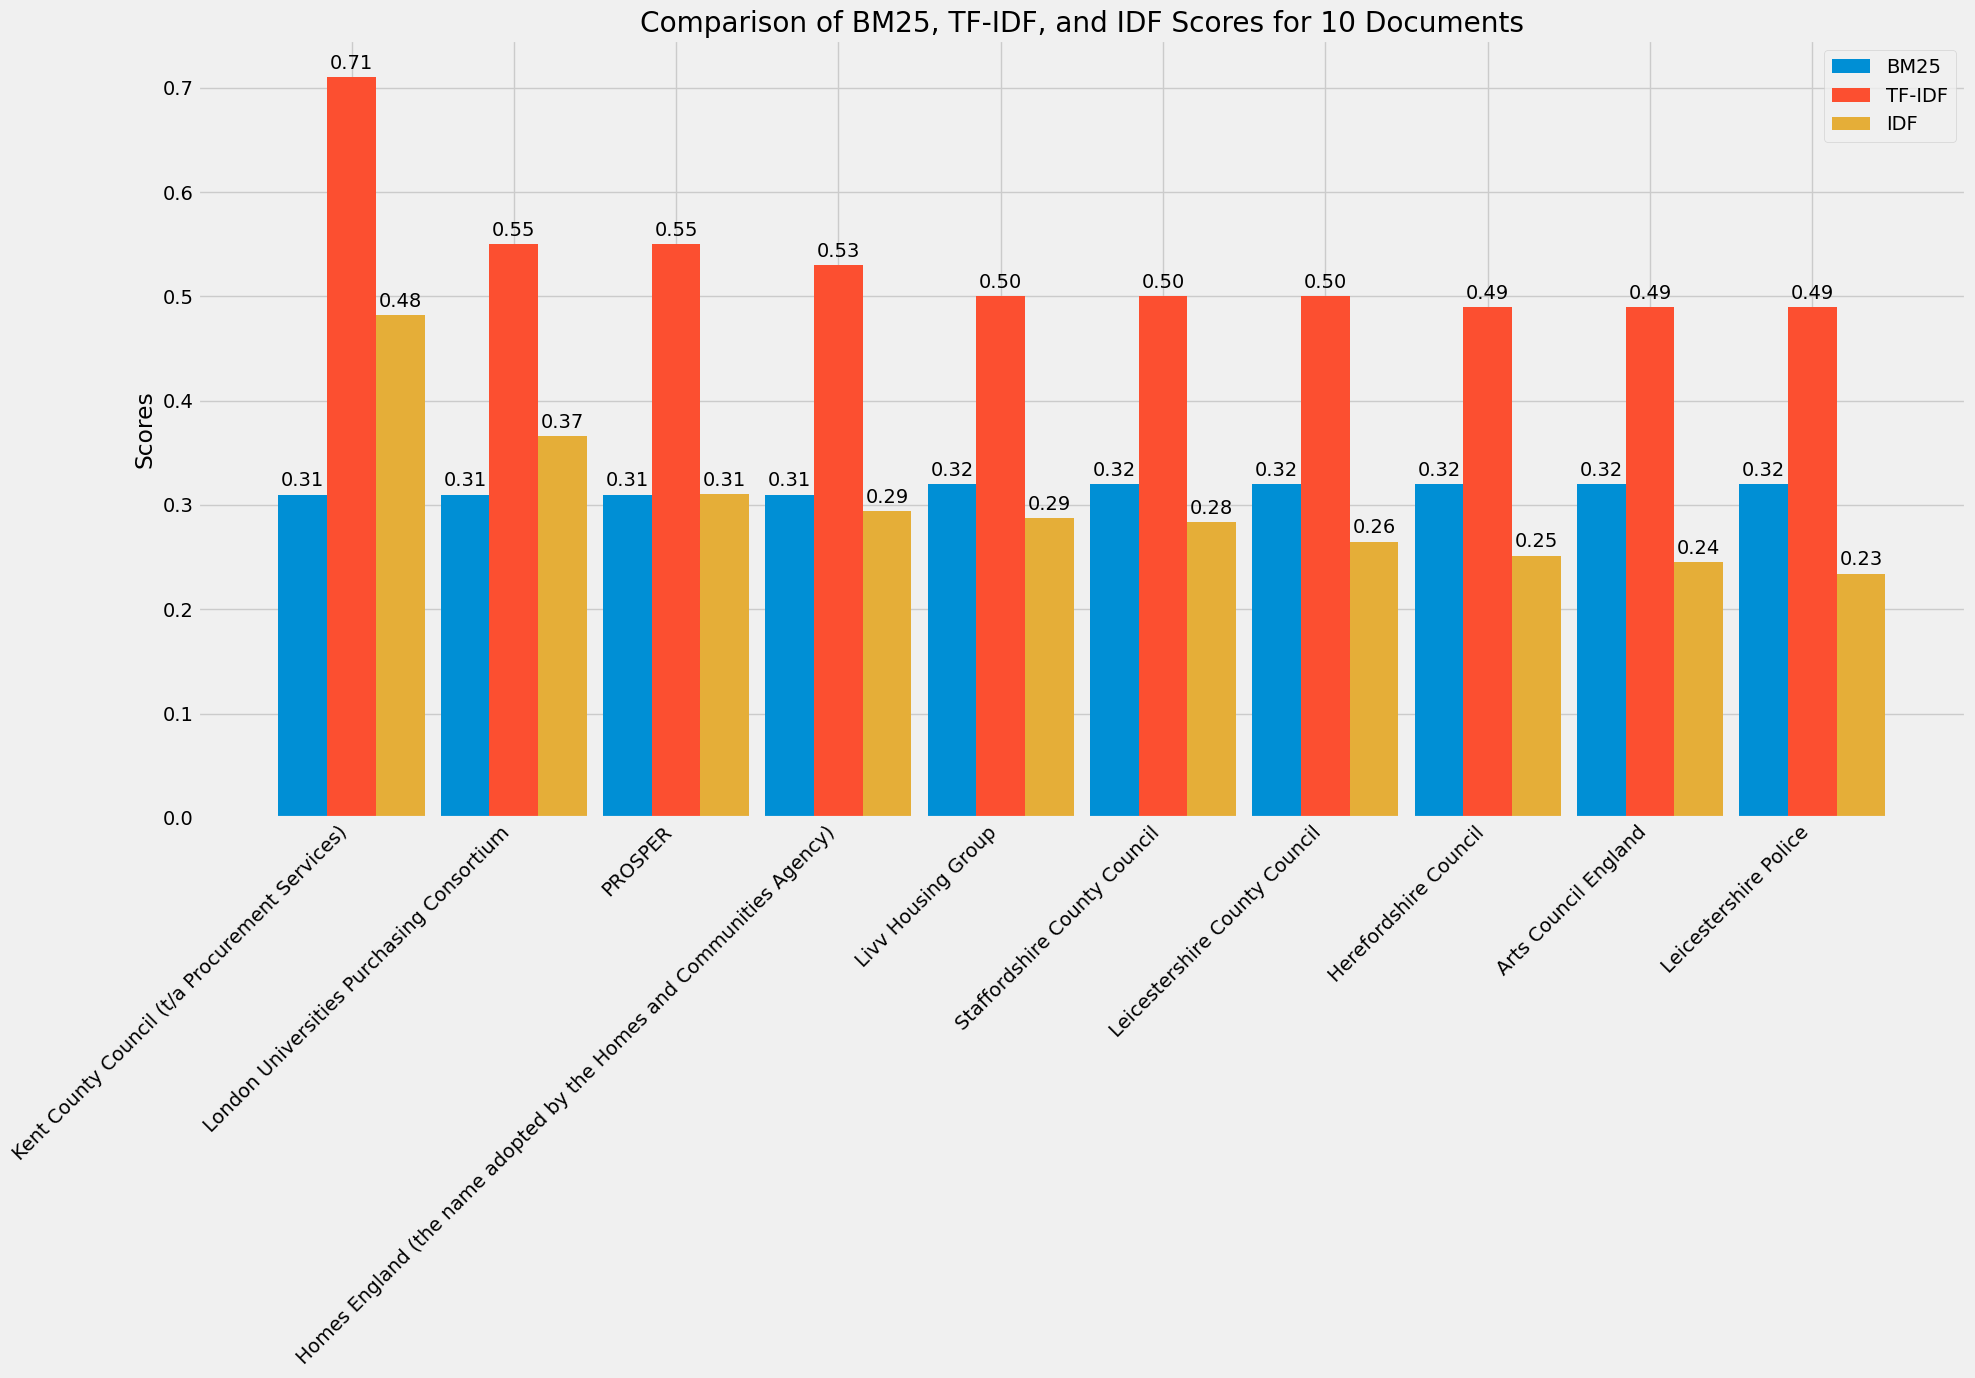

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Comaparison between the two models as a form of a bar chart 

relevant_docs_df = pd.DataFrame(list(zip(relevant_docs)), columns=['Relevant Documents'])


bm25_scores = results_df['Similarity Score (BM25)'].values
tfidf_scores = top_10_docs_df['Similarity Score (TF-IDF)'].values
idf_scores = top_10_idf_docs_df['Similarity Score (IDF)'].values
#document_names = relevant_docs_df['Relevant Documents'].values
document_names = results_df['Relevant Documents (Tender_by)'].values


ind = np.arange(len(bm25_scores))  
width = 0.3

fig, ax = plt.subplots(figsize=(20, 14))
rects1 = ax.bar(ind - width, bm25_scores, width, label='BM25')
rects2 = ax.bar(ind, tfidf_scores, width, label='TF-IDF')
rects3 = ax.bar(ind + width, idf_scores, width, label='IDF')

ax.set_ylabel('Scores')
ax.set_title('Comparison of BM25, TF-IDF, and IDF Scores for 10 Documents')
ax.set_xticks(ind)
ax.set_xticklabels(document_names, rotation=45, ha='right')
ax.legend()

# Attach a text label above each bar displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()



In [24]:
# Comparison of the three evaluation metrics between the two models 

bm25_precision = 0.20
bm25_recall = 0.33
bm25_f1_score = 0.25

tfidf_precision = 0.17
tfidf_recall = 0.33
tfidf_f1_score = 0.22

idf_precision = 0.10
idf_recall = 0.33
idf_f1_score = 0.15

comparison_data = {
    'Model': ['BM25', 'TF-IDF', 'IDF'],
    'Precision': [bm25_precision, tfidf_precision, idf_precision],
    'Recall': [bm25_recall, tfidf_recall, idf_recall],
    'F1-score': [bm25_f1_score, tfidf_f1_score, idf_f1_score]
}

comparison_df = pd.DataFrame(comparison_data)
print("Evaluation Metrics Comparison:")
display(comparison_df)

Evaluation Metrics Comparison:


,Model,Precision,Recall,F1-score
0,BM25,0.20,0.33,0.25
1,TF-IDF,0.17,0.33,0.22
2,IDF,0.10,0.33,0.15


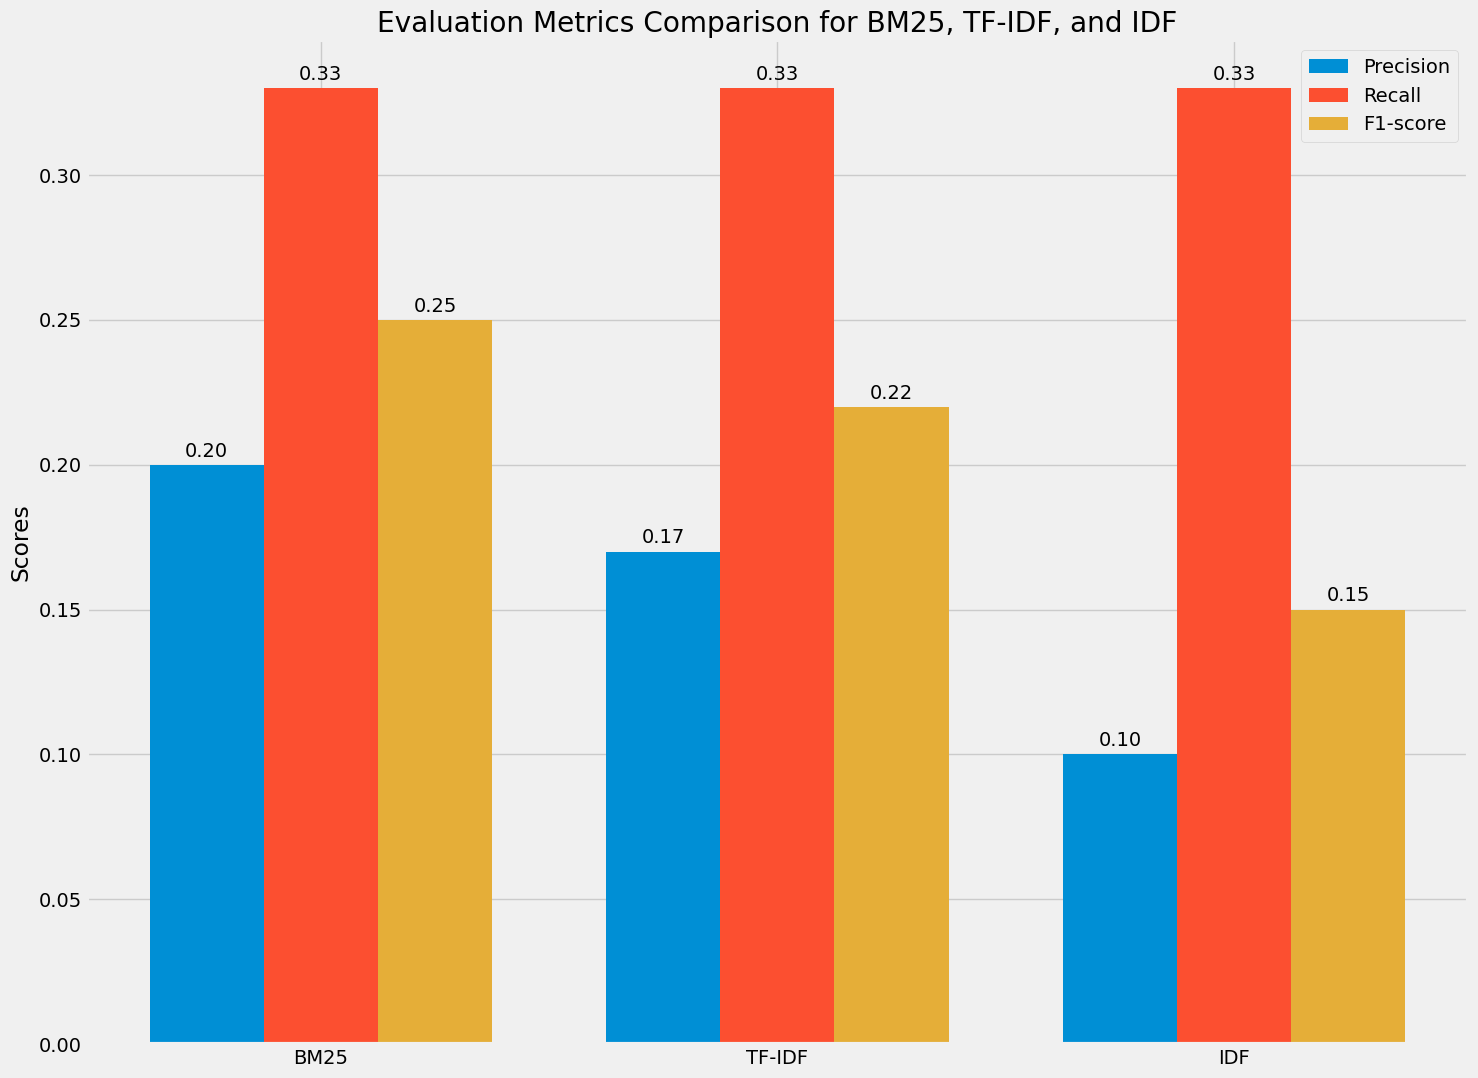

In [25]:
ind = np.arange(len(comparison_df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 11))
rects1 = ax.bar(ind - width, comparison_df['Precision'], width, label='Precision')
rects2 = ax.bar(ind, comparison_df['Recall'], width, label='Recall')
rects3 = ax.bar(ind + width, comparison_df['F1-score'], width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics Comparison for BM25, TF-IDF, and IDF')
ax.set_xticks(ind)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()
